In [18]:
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")

llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")


In [19]:
def add(a:int,b:int):
    ''' add a and b 
        a:int
        b:int

        returns: 
        (a+b):int
    '''
    return a+b
def multiply(a:int,b:int):
    ''' add a and b 
        a:int
        b:int

        returns: 
        (a*b):int
    '''
    return a*b
def divide(a:int,b:int):
    ''' add a and b 
        a:int
        b:int

        returns: 
        (a/b):int
    '''
    return a/b

tools=[add,multiply,divide]
llm_with_tools=llm.bind_tools(tools)

In [20]:
from langgraph.graph import StateGraph,START,END,MessagesState
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,SystemMessage,HumanMessage

syt_msg= SystemMessage(content="You are a helpful assistant that tries to use the given tools and give the output.")

def human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([syt_msg]+state["messages"])]}

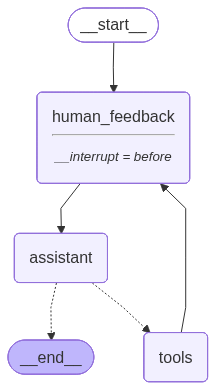

In [24]:
from langgraph.graph import MessagesState, StateGraph,START,END
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition,ToolNode
from pprint import pprint 
graph=StateGraph(MessagesState)
graph.add_node("human_feedback",human_feedback)
graph.add_node("assistant",assistant)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"human_feedback")
graph.add_edge("human_feedback","assistant")
graph.add_conditional_edges("assistant",tools_condition)
graph.add_edge("tools","human_feedback")
graph.add_edge("assistant",END)
builder=graph.compile(interrupt_before=["human_feedback"],checkpointer=MemorySaver())
display(Image(builder.get_graph().draw_mermaid_png()))

In [26]:
ini_msg={"messages":"add 5+100 and then divide it by (10+5)"}
config={"configurable":{"thread_id":"12"}}
for event in builder.stream(ini_msg,config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

add 5+100 and then divide it by (10+5)


In [27]:
#get the user input
user_inp=input("Tell me what do you want to update-->")
builder.update_state(config,{"messages":user_inp},as_node="human_feedback")

for event in builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

add 2+1
================================== Ai Message ==================================
Tool Calls:
  add (e616aa57-1518-4d6d-b7b9-10e45b49d86d)
 Call ID: e616aa57-1518-4d6d-b7b9-10e45b49d86d
  Args:
    a: 5
    b: 100
================================= Tool Message =================================
Name: add

105


In [28]:
for event in builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

105
================================== Ai Message ==================================
Tool Calls:
  add (a467219f-5ed7-4594-a771-b872f976bc70)
 Call ID: a467219f-5ed7-4594-a771-b872f976bc70
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15
